# 0 Preliminaries
In this section we deal with imports and parameters for the execution of the reste of the code

In [104]:
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import os
import scipy.optimize as optim
import math
import time

In [74]:
# Path to the folder of images
#database_path = '/home/dimitribouche/Bureau/ENSAE/CompressedSensing/CroppedYale'
database_path = '/Users/Remi/Documents/ENSAE/3A/Compressed Sensing/Reconaissance faciale/CroppedYale'
# Proportion of data to be used for learning (used for testing : 1 - learn_slice)
learn_slice = 0.99

# 1 Data base treatment
## 1.1 Read pgm function
In this subsection, we introduce a function to read the pgm images and store them in a numpy array

In [4]:
def read_pgm(pgmf):
    """
    Create a numpy array from a .pgm image file
    
    Args:
        pgmf (file) : a .pgm file opened in python
    Returns:
        numpy.ndarray. The .pgm file as a 2d numpy array
    """
    # Make sure that 
    #assert pgmf.readline() == 'P5\n'
    pgmf.readline().split()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    image = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        image.append(row)
    return np.array(image)


[[ 24  22  22 ...  80  83  85]
 [ 24  22  20 ...  72  77  79]
 [ 22  20  19 ...  63  68  73]
 ...
 [ 69  71  74 ... 115 114 113]
 [ 64  68  71 ... 114 111 109]
 [ 63  66  70 ... 114 112 110]]


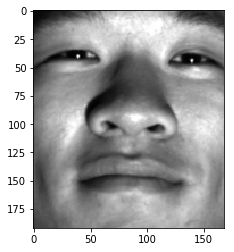

In [5]:
# Test of the read_pgm function on a given image
testfile = open(database_path + '/yaleB13/yaleB13_P00A-010E-20.pgm', 'rb')
testimage = read_pgm(testfile)
print(testimage)

# Show the image
plt.imshow(testimage, cmap="gray")
plt.show()

## 1.2 Load full database
In this subsection, we use our pgm reader to loop over the folders and files in the database to load the full database

In [6]:
def load_database(path, flatten=True):
    """
    Load the face database from computer
    
    Args:
        path (str): the folder containing the 'CroppedYale' folder
        flatten (bool): Should images be flattened ?
    
    Returns:
        list. A list of list of numpy array. Index of first list is for the individual, 
        index of the second list is the index of the image of the individual
    """
    database = []
    count = 0
    # Each folder contains the pictures for a given individual
    # We loop over folders
    for foldername in os.listdir(path):
        # Create empty container for the images of the individual
        database.append([])
        # Loop over images
        for filename in os.listdir(path + '/' + foldername):
            # Load only images files
            if filename.endswith(".pgm"):
                # Open file
                im = open(path + '/' + foldername + '/' + filename, 'rb')
                # Convert to numpy array, jump file is conversion is not a success
                try :
                    im_np = read_pgm(im)
                except ValueError :
                    # Skip the file "ambient" which are pictures of the background of the faces, unecessary in our case
                    continue
                # Append the new image to the list of images of the individual
                if flatten:
                    database[count].append(im_np.flatten())
                else:
                    database[count].append(im_np)
        count += 1
    return database

In [7]:
# Load the Yale B extended database using our loader
data = load_database(database_path, flatten=False)

In [8]:
print(data)

[[array([[80, 80, 84, ..., 63, 67, 71],
       [81, 79, 78, ..., 60, 61, 64],
       [80, 79, 82, ..., 61, 59, 62],
       ...,
       [12, 12, 19, ..., 21, 18, 14],
       [12, 12, 15, ..., 14, 14, 14],
       [12, 12, 12, ..., 12, 12, 11]]), array([[94, 94, 96, ..., 72, 76, 79],
       [87, 87, 94, ..., 66, 72, 75],
       [88, 91, 95, ..., 70, 68, 67],
       ...,
       [ 5,  7,  8, ...,  8,  9,  7],
       [ 5,  7,  8, ...,  7,  8,  9],
       [ 4,  7,  7, ...,  6,  7,  8]]), array([[59, 66, 77, ..., 73, 67, 58],
       [67, 76, 82, ..., 71, 72, 72],
       [66, 75, 84, ..., 79, 76, 76],
       ...,
       [ 4,  4,  4, ...,  3,  7,  6],
       [ 4,  5,  5, ...,  4,  5,  6],
       [ 3,  4,  5, ...,  5,  7,  7]]), array([[16, 18, 22, ..., 13, 13, 12],
       [14, 17, 19, ..., 13, 14, 14],
       [14, 16, 18, ..., 12, 13, 11],
       ...,
       [ 1,  2,  2, ...,  3,  5,  5],
       [ 1,  2,  1, ...,  4,  4,  5],
       [ 1,  1,  1, ...,  7,  6,  5]]), array([[69, 71, 77, ..., 53, 5

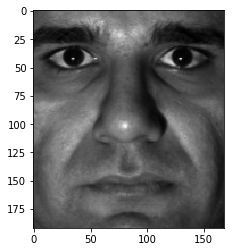

In [9]:
# Test : show a face in the database
# The index states that this is the 9th image for the 7th individual
plt.imshow(data[7][9], cmap="gray")
plt.show()

## 1.3 Division of the data in test/learn sets
In this subsection we introduce the divide_learn_test function that divide the database two : a learn set and a test set

In [65]:
def divide_learn_test(faces_data, learn_slice=0.5):
    """
    Divide the faces database into a learn set and a test set
    
    Args : 
        faces_data (list) : The database in the format of output from load_database function
        learn_slice (float) : How much of the database should be used for learning ? (0.5 : half)
    
    Returns :
        tuple. A tuple of list, the learn set and the test set
    """
    learn_data = []
    test_data = []
    nb_pers=len(faces_data)
    nb_learn_im_per_pers=np.zeros(nb_pers)
    nb_test_im_per_pers=np.zeros(nb_pers)
    for person in range(0, len(faces_data)):
        n_images = len(faces_data[person])
        shuffle(faces_data[person])
        split_index = int(learn_slice * n_images)
        nb_learn_im_per_pers[person]=split_index
        nb_test_im_per_pers[person]=n_images-split_index
        learn_data.append(faces_data[person][0: split_index])
        test_data.append(faces_data[person][split_index: ])
    return learn_data, test_data, nb_learn_im_per_pers, nb_test_im_per_pers

In [127]:
# Divide data base in learn and test using the divide_learn_test function
data_learn, data_test, nb_learn_im_per_pers, nb_test_im_per_pers= divide_learn_test(data, learn_slice=learn_slice)

## 1.4 Stack learn data in a matrix
In this section we introduce a function to stack the learn data in a matrix. Each image is vectorized and each vector $A_k$ is stacked column by column into a matrix $A$.
$$A = [A_1|A_2|...|A_N]$$

In [78]:
def stack_images(faces_data):
    """
    input: list of face images
    output: np.array. Matrix of vectorized image concatenated into columns
    """
    dim_stacked = faces_data[0][0].shape[0] * faces_data[0][0].shape[1]
    n_images = sum([len(faces_data[i]) for i in range(0, len(faces_data))])
    images_matrix = np.zeros(shape=(dim_stacked, n_images), dtype=np.int64)
    cum_ind = 0
    for i in range(0, len(faces_data)):
        len(faces_data[i])
        for j in range(0, len(faces_data[i])):
            images_matrix[:, j + cum_ind] = faces_data[i][j].flatten().T
        cum_ind += len(faces_data[i])
    return images_matrix

In [79]:
# Create and fill the matrix of images using the stack_images function defined above
im_mat = stack_images(data_learn)
print(im_mat)
print(im_mat.shape)

[[ 53   6  34 ...  44 101 106]
 [ 55   7  37 ...  46 104 111]
 [ 60   8  42 ...  49 109 117]
 ...
 [ 23  20  28 ...   7   0   4]
 [ 26  34  32 ...   2   0   4]
 [ 32  49  38 ...   2   0   4]]
(32256, 2386)


## 1.5 Stack test data in vectors
In this section we introduce a function to stack the test data in list of vectors

In [80]:
# Create and fill the vectors of test images using the stack_images function defined above
def stack_data_to_vec(data_test):
    test_im_mat = stack_images(data_test)
    nb_cols = test_im_mat.shape[1]
    test_im_vec = []
    for i in range(0,nb_cols):
        test_im_vec.append(np.array(test_im_mat[:,i]))
    nb_test_im = len(test_im_vec)
    N = len(test_im_mat[:,0])
    return test_im_vec, nb_test_im, N

In [81]:
test_im_vec, nb_test_im, N = stack_data_to_vec(data_test)
print(nb_test_im)
print(N)
print(test_im_vec)

38
32256
[array([ 4,  4,  4, ..., 56, 58, 68], dtype=int64), array([ 60,  64,  66, ..., 127, 124, 124], dtype=int64), array([205, 216, 229, ...,   9,   8,   7], dtype=int64), array([ 4,  5,  6, ..., 15, 16, 16], dtype=int64), array([13,  8, 10, ..., 16, 17, 18], dtype=int64), array([179, 185, 188, ...,  11,  11,  12], dtype=int64), array([72, 79, 85, ...,  0,  0,  1], dtype=int64), array([91, 90, 90, ...,  9, 10, 10], dtype=int64), array([15, 18, 22, ..., 37, 26, 22], dtype=int64), array([76, 75, 74, ..., 40, 32, 23], dtype=int64), array([115, 114, 110, ...,  14,  12,  10], dtype=int64), array([25, 26, 28, ..., 40, 39, 39], dtype=int64), array([187, 188, 188, ...,  16,  15,  16], dtype=int64), array([99, 96, 97, ...,  5,  5,  4], dtype=int64), array([90, 95, 97, ...,  0,  1,  1], dtype=int64), array([ 8,  6,  4, ..., 79, 75, 71], dtype=int64), array([ 91, 102,  89, ...,  12,  12,  11], dtype=int64), array([  7,   6,   7, ..., 128, 119, 116], dtype=int64), array([3, 3, 3, ..., 6, 6, 5],

# 2 Resolution of optimization programm
## 1.1 Brief presentation of the method

The aim is to explain **briefly** the origin of the algorithm we apply because it is not a standard algorithm. We strongly rely on the paper **A fast and accurate algorithm for $l_1$ minimization problems in compressive sampling** published in *Journal on Advances in Signal Processing* (2015) from F. Chen, L. Shen, B.W. Suter and Y. Xu.
No proof is given.

As we have seen during the course the Basis Pursuit (BP) problem can be relaxed as:
$$ \min\{||u||_1: u \in R^N\}$$ s.t. $$||Au-y||_2\leq \epsilon$$

We convert the constrained
optimization problems to unified unconstrained one via
an indicator function:

$$B_{\epsilon}=\{||x||_2 \leq \epsilon; x \in R^m\}$$

$$
i_C(u) := \left\{
    \begin{array}{ll}
        0 & \mbox{if } u \in C \\
        +\infty & \mbox{otherwise.}
    \end{array}
\right.
$$

Then (BP) with noise becomes the unconstrained optimization problem:

$$ \min\{||u||_1+i_{B_{\epsilon}}(Au-y): u \in R^N \} $$

There exists a characterization of the solution of such problem using proximity operator and subdifferentials:

* $prox_{\lambda f}(x):=argmin\{\frac{1}{2\lambda}||u-x||_2^2+f(u): u \in R^d\}$
* $\partial \psi(u):=\{ v \in R^d: \psi(w) \ge \psi(u)+ <v,w-u>, \forall w \in R^d \}$

Now, with the help of the subdifferential and the proximity
operator, we can characterize a solution of the
indicator function based on model (2) via fixed-point
equations.

If $u \in R^N$ is a solution to the unconstrained optimization problem then for any $\alpha>0$ and $\beta>0$, there exists a vector $v \in R^m$ such that:

$$ u=prox_{\frac{1}{\alpha}||.||_1}(u-\frac{\beta}{\alpha}A^Tv)$$
$$ v=(I-prox_{i_{B_{\epsilon}(.-y)}})(Au+v)$$
And reciprocally.

Fortunately enough,
these proximity operators have explicit expressions

Equivalently, by introducing an auxiliary variable w:
$$ u=prox_{\frac{1}{\alpha}||.||_1}((I-\frac{\beta}{\alpha}A^TA)u-\frac{\beta}{\alpha}A^T(v-w))$$
$$w=prox_{i_{B_{\epsilon}(.-y)}}(Au+v)$$
$$ v=Au+v-w$$

An iterative algorithm for finding the
fixed-point following the iterative scheme is then developed:

$$ u^{k+1}=prox_{\frac{1}{\alpha}||.||_1}((I-\frac{\beta}{\alpha}A^TA)u^{k}-\frac{\beta}{\alpha}A^T(v^{k}-w^{k}))$$
$$w^{k+1}=prox_{i_{B_{\epsilon}(.-y)}}(Au^{k+1}+v^{k})$$
$$ v=Au^{k+1}+v^{k}-w^{k+1}$$

Note one important condition to have the convergence of the algorithm:
$$\frac{\beta}{\alpha}<\frac{1}{||A||^2}$$

Here we don't use this version of the algorithm but a variant that is computationnally more efficient.

## 2.2 Example on one image test
In this subsection, we provide an example of how our algorithm works. We pick one test image, then we provide a label and finally we test if this label was the good one.

### 2.2.1 Initialization of the parameters

In [131]:
#Input
A = im_mat
At = np.transpose(A)
y = test_im_vec[0]
m = A.shape[0]
N = A.shape[1]
print(A.shape)
print(At.shape)
print(y.shape)

(32256, 2386)
(2386, 32256)
(32256,)


In [132]:
#Define some functions
def shrink(x,lamb):
    n=len(x)
    s=np.zeros(n)
    for i in range(n):
        if x[i]>lamb:
            s[i]=x[i]-lamb
        elif x[i]<-lamb:
            s[i]=x[i]+lamb
    return s
    
def norm1(x):
    return np.linalg.norm(x,1)

def norm2(x):
    return np.linalg.norm(x,2)

In [133]:
#set the parameters
u=np.zeros(N)
v1=np.zeros(m)
v0=v1-(A.dot(u))
eps=0.1

normA=np.linalg.norm(A)
alpha=(m/N)*20*(normA**2)/np.linalg.norm(At.dot(y),np.inf)
beta=0.999*alpha/(normA**2)
bona=beta/alpha

T=6
tau=4
l=20

max_iter=200

### 2.2.2 Optimization resolution

In [134]:
#a variant
tmps1=time.time()
for k in range(max_iter):
    #step 1
    u=shrink(u-bona*At.dot(2*v1-v0),1/alpha)
    #step 2
    p=A.dot(u)+v1-y
    v0=v1
    if norm2(p)<eps:
        v1=0
    else:
        v1=(1-eps/norm2(p))*p
    #step 3
    if k%l==0 and T<20:
        alpha=tau*alpha
        beta=tau*beta
        bona=beta/alpha
        T+=1
    print(k,'th iteration')
tmps2=time.time()-tmps1
print("Temps d'execution = %f" %tmps2)

0 th iteration
1 th iteration
2 th iteration
3 th iteration
4 th iteration
5 th iteration
6 th iteration
7 th iteration
8 th iteration
9 th iteration
10 th iteration
11 th iteration
12 th iteration
13 th iteration
14 th iteration
15 th iteration
16 th iteration
17 th iteration
18 th iteration
19 th iteration
20 th iteration
21 th iteration
22 th iteration
23 th iteration
24 th iteration
25 th iteration
26 th iteration
27 th iteration
28 th iteration
29 th iteration
30 th iteration
31 th iteration
32 th iteration
33 th iteration
34 th iteration
35 th iteration
36 th iteration
37 th iteration
38 th iteration
39 th iteration
40 th iteration
41 th iteration
42 th iteration
43 th iteration
44 th iteration
45 th iteration
46 th iteration
47 th iteration
48 th iteration
49 th iteration
50 th iteration
51 th iteration
52 th iteration
53 th iteration
54 th iteration
55 th iteration
56 th iteration
57 th iteration
58 th iteration
59 th iteration
60 th iteration
61 th iteration
62 th iteration
63

Text(0.5,1,'Représentation de la solution')

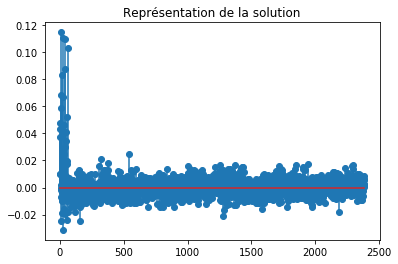

In [135]:
plt.stem(u)
titre = 'Représentation de la solution'
plt.title(titre)

### 2.2.3 Attribution of a label
In this subsection, we define a function that will give a label (index of the person) for the solution of the optimization problem we previously found. We simply compute the residuals and take the index of the person that minimizes the residuals.

In [116]:
#attribute the label

def labelise(data_learn,y,A,u,nb_learn_im_per_pers):
    N=len(u)
    nb_pers=len(data_learn)
    res=np.zeros(nb_pers)
    index_pers_A=np.append(0,np.cumsum(nb_learn_im_per_pers))
    for pers in range(nb_pers):
        beg=int(index_pers_A[pers])
        end=int(index_pers_A[pers+1])
        u_trunc=np.zeros(N)
        u_trunc[beg:end]=u[beg:end]
        res[pers]=norm2(y-A.dot(u_trunc))
    label=np.argmin(res)  
    return label

In [123]:
labelise(data_learn,y,A,u,nb_learn_im_per_pers)

37

## 2.3 Computation of the success rate for 1 image test per person
In this subsection, we simply apply the same methodology as previously but for one test image per person. Finally we compute the success rate of ou prediction.

In [ ]:
normA=np.linalg.norm(A)

In [120]:
#rate of success for 1 test per person

tmps1=time.time()

nb_test=len(nb_test_im_per_pers)
A = im_mat
At = np.transpose(A)
m = A.shape[0]
N = A.shape[1]
eps=0.1
T=6
tau=4
l=20
max_iter=400
count=0

for person in range(nb_test):
    print(person,'test image processing')
    #Input
    y = test_im_vec[person]
    #init
    u=np.zeros(N)
    v1=np.zeros(m)
    v0=v1-(A.dot(u))
    alpha=(m/N)*20*(normA**2)/np.linalg.norm(At.dot(y),np.inf)
    beta=0.999*alpha/(normA**2)
    bona=beta/alpha
    
    for k in range(max_iter):
        #step 1
        u=shrink(u-bona*At.dot(2*v1-v0),1/alpha)
        #step 2
        p=A.dot(u)+v1-y
        v0=v1
        if norm2(p)<eps:
            v1=0
        else:
            v1=(1-eps/norm2(p))*p
        #step 3
        if k%l==0 and T<20:
            alpha=tau*alpha
            beta=tau*beta
            bona=beta/alpha
            T+=1
    
    #attribute a label thanks to computation of the residuals
    label=labelise(data_learn,y,A,u,nb_learn_im_per_pers)
    
    #count if right
    if label==person:
        count+=1
        print('good prediction!')
        
#success rate
rate=count/nb_test
print(rate)

tmps2=time.time()-tmps1
print("Temps d'execution = %f" %tmps2)

0 test image processing
good prediction!
1 test image processing
good prediction!
2 test image processing
good prediction!
3 test image processing
good prediction!
4 test image processing
good prediction!
5 test image processing
good prediction!
6 test image processing
good prediction!
7 test image processing
good prediction!
8 test image processing
good prediction!
9 test image processing
good prediction!
10 test image processing
good prediction!
11 test image processing
good prediction!
12 test image processing
good prediction!
13 test image processing
good prediction!
14 test image processing
good prediction!
15 test image processing
good prediction!
16 test image processing
good prediction!
17 test image processing
good prediction!
18 test image processing
good prediction!
19 test image processing
good prediction!
20 test image processing
good prediction!
21 test image processing
good prediction!
22 test image processing
good prediction!
23 test image processing
good prediction!
24